# Process ACCESS-ESM1-5 to NEM region

In [3]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [105]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '00:30:00'
cores = 24
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52+gdata/fs38'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])
                     # python=os.environ["DASK_PYTHON"])

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39981 instead
  warnings.warn(


In [106]:
cluster.scale(jobs=1)
client = Client(cluster)

In [107]:
client#.restart()

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/39981/status,
Dashboard: /proxy/39981/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.4:40715,Workers: 0
Dashboard: /proxy/39981/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
import xarray as xr
import functools

import os

In [9]:
models = [
    "ACCESS-ESM1-5"
]

In [10]:
def get_model_path(model):
    """
    Return the path to the historical simulations
    """
    if model == "ACCESS-ESM1-5":
        return "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/"
    else:
        raise ValueError("Incorrect model")

In [33]:
def get_model_grid(model):
    """
    Return the string for the model grid
    """
    if model == "ACCESS-ESM1-5":
        return "gn"
    else:
        raise ValueError("Incorrect model")

In [41]:
def sel_Aus(ds, lat_name="lat", lon_name="lon"):
    """
    Select Australian region.
    """
    return ds.sel({lon_name: slice(110, 155), lat_name: slice(-45, -10)})

In [45]:
def open_model_data(model, variable, time, preprocess):
    """
    Concat historical runs from 1950 for all ensemble members.
    
    model: str, model name.
    variable: str, variable name
    time: str, name of time interval e.g. day
    preprocess: function to pass to preprocess in open_mfdataset
    """
    model_path = get_model_path(model)
    model_grid = get_model_grid(model)
    members = os.listdir(model_path)
    
    ds_list = []
    for member in members:
        filename = variable + "_" + time + "_" + model + "_historical_" + member + "_" + model_grid
        path = model_path + member + "/" + time + "/" + variable + "/" + model_grid + "/latest/" + filename

        # Open data and preprocess
        ds = xr.open_mfdataset([
            path + "_19500101-19991231.nc",
            path + "_20000101-20141231.nc"
        ],
            join="exact",
            preprocess=preprocess,
            engine="netcdf4",
            compat="override",
            coords="minimal",
        )
        
        # Assign member dimension
        m = int(member.split("i")[0][1:])
        ds = ds.expand_dims({"member": [m]})
        ds_list.append(ds)
        
    return xr.concat(ds_list, dim="member").sortby("member")

In [47]:
def chunk_member(ds, chunks):
    """
    Re-chunk member dimension.
    """
    return ds.chunk({"member": chunks})

In [48]:
def to_zarr(ds, model, variable, time, region):
    """
    Write to zarr collection.
    """
    filename = variable + "_" + time + "_" + model + "_historical_1950-2014_" + region + ".zarr"
    path = "/g/data/w42/dr6273/work/data/CMIP6/" + model + "/historical/" + time + "/" + variable + "/" + filename
    ds.to_zarr(
        path,
        mode="w",
        consolidated=True
    )

In [80]:
def open_chunk_write(model, variable, time, region, preprocess, member_chunks=5):
    """
    Open model data, concat alomng member, chunk and write to zarr
    
    model: str, model name.
    variable: str, variable name
    time: str, name of time interval e.g. day
    region: str, name of region for filename
    preprocess: function to pass to preprocess in open_mfdataset
    member_chunks: how many chunks for members before writing
    """
    ds = open_model_data(model, variable, time, preprocess)
    ds = chunk_member(ds, member_chunks)
    to_zarr(ds, model, variable, time, region)

In [113]:
def preprocess(variable):
    """
    Preprocess for open_mfdataset. Uses functools.partial to return a function 
    that only takes one argument.
    """
    def _preprocess(d, v):
        if v in ["tas", "tasmax", "sfcWind"]:
            d = d.drop("height")
        d = d[v].to_dataset(name=v)
        return sel_Aus(d)
    
    return functools.partial(_preprocess, v=variable)

### Temperature (2m)

In [75]:
%%time
open_chunk_write(
    "ACCESS-ESM1-5",
    "tas",
    "day",
    "AUS",
    preprocess("tas")
)

CPU times: user 14.2 s, sys: 2.08 s, total: 16.3 s
Wall time: 59.2 s


### Daily max temperature (2m)

In [90]:
%%time
open_chunk_write(
    "ACCESS-ESM1-5",
    "tasmax",
    "day",
    "AUS",
    preprocess("tasmax")
)

CPU times: user 1min 10s, sys: 16.9 s, total: 1min 27s
Wall time: 6min 35s


### Shortwave radiation at surface

In [92]:
%%time
open_chunk_write(
    "ACCESS-ESM1-5",
    "rsds",
    "day",
    "AUS",
    preprocess("rsds")
)

CPU times: user 1min 11s, sys: 17.3 s, total: 1min 28s
Wall time: 6min 43s


### Precip

In [98]:
# %%time
# open_chunk_write(
#     "ACCESS-ESM1-5",
#     "pr",
#     "day",
#     "AUS",
#     preprocess("pr")
# )

### Surface wind speed (~10 m)

In [114]:
%%time
open_chunk_write(
    "ACCESS-ESM1-5",
    "sfcWind",
    "day",
    "AUS",
    preprocess("sfcWind")
)

CPU times: user 22.9 s, sys: 4.65 s, total: 27.6 s
Wall time: 1min 38s


### 100 m wind

Not available from model so use a power law. From van der Wiel at al (2019):https://www.sciencedirect.com/science/article/pii/S1364032119302862#sec3

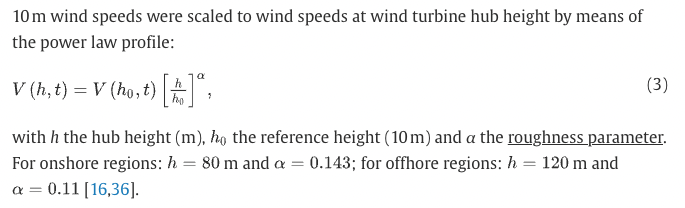

In [100]:
def power_law(ds, new_height=100, ref_height=10, roughness=0.143):
    """
    Scale wind speed to new height.
    """
    return ds * (new_height / ref_height) ** roughness

In [118]:
def sfcWind_to_100m(model, region):
    """
    Rescale sfcWind and write
    """
    path = "/g/data/w42/dr6273/work/data/CMIP6/" + model + "/historical/day/"
    
    w10 = xr.open_zarr(
        path + "sfcWind/sfcWind_day_" + model + "_historical_1950-2014_" + region + ".zarr/",
        consolidated=True
    )["sfcWind"]
    w100 = power_law(w10)
    w100 = w100.to_dataset(name="w100")
    w100.to_zarr(
        path + "w100/w100_day_" + model + "_historical_1950-2014_" + region + ".zarr/",
        mode="w",
        consolidated=True
    )

In [119]:
sfcWind_to_100m("ACCESS-ESM1-5", "AUS")

# Close cluster

In [120]:
client.close()
cluster.close()